# **VitOcNet**



*   The aim is to enhance the performance of the Occupancy Network by incorporating the Vision Transformer architecture into the model.





### **Install Binary Dependencies**

*   Compile the extension modules.



In [ ]:
!pip install pandas
!pip install plyfile
!pip install tensorboard
!pip install git+https://github.com/huggingface/transformers
!pip install timm

In [ ]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!python setup.py build_ext --inplace

### **Dataset**
*   Download the preprocessed ShapeNet dataset (73.4 GB).
*   Unpack the data into the data/ folder.






In [ ]:
import os
os.chdir('data/')
!wget https://s3.eu-central-1.amazonaws.com/avg-projects/occupancy_networks/data/dataset_small_v1.1.zip

In [ ]:
!unzip dataset_small_v1.1.zip
os.chdir('../')

### **Imports**

In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
from data import dataset
from mesh_generate import generate
from models import OccupancyNetwork
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from torch.utils import data
from torch import distributions as dist
from tqdm import trange, tqdm
from training import train
from utils.checkpoints import CheckpointIO
from utils.common import compute_iou, make_3d_grid
from utils.io import export_pointcloud, load_pointcloud
from utils.mesh import VoxelGrid
from utils.visualize import visualize_data
from utils import visualize as vis
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import time
import torch
import torch.optim as optim
import trimesh
import yaml
matplotlib.use('Agg')

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade pandas
!pip install --upgrade cython
!pip install --upgrade scikit-learn
from evaluation.eval_meshes import MeshEvaluator

Test whether a GPU was detected by pytorch.

In [2]:
torch.cuda.is_available()

True

### **1. Occupancy Networks: Learning 3D Reconstruction in Function Space**

Paper: [Occupancy Networks - Learning 3D Reconstruction in Function Space](https://arxiv.org/abs/1812.03828)

---


#### **1.1 Approach**



*   Instead of reconstructing a 3D shape in the form of a (discrete) voxel grid, point cloud, or mesh from the input data, occupancy networks return a function that predicts an occupancy probability for a continuous 3D point in R^3.



#### **1.2 Network Architecture**


*   The network architecture is generally the same across different tasks (e.g. single image 3D reconstruction or point cloud completion) with the task-specific ***encoder*** being the only changing element.



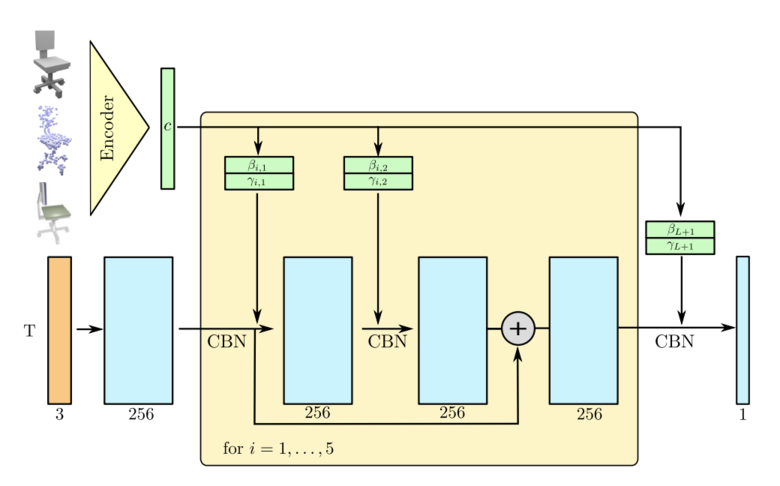

*   Once the task encoder has produced the embedding c, it is passed as input along with the batch of T sampled 3D points, which are processed by 5 sequential ResNet blocks. To condition the network output on the input embedding c, [Conditional Batch Normalization](https://paperswithcode.com/method/conditional-batch-normalization) is used.



*   For single image 3D reconstruction the network uses a ResNet-18 encoder with altered last layer to produce 256-dim embeddings.




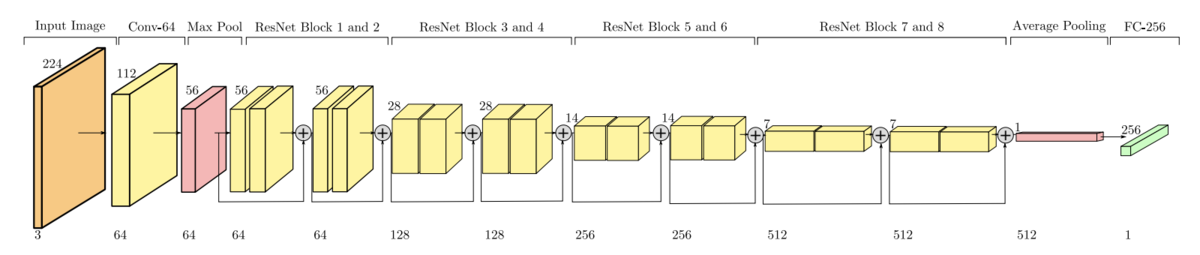

### **2. ViT: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**

*Paper*: [ViT: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

---


#### **2.1 ViT Architecture**



![vit.png](images/vit.png)

ViT has two major components:

* A Patch Embedding Module
* A Transformer Encoder


ViT takes an input image and divides it into fixed-size patches, which are then linearly embedded to obtain a sequence of embeddings. The positional encodings are added to these embeddings to provide spatial information.
The sequence of embeddings is then fed into the Transformer encoder, which processes them using multi-head self-attention layers.

![vit_patch.jpg](images/vit_patch.jpg)



* The Transformer encoder enriches embeddings through the multi-head self-attention layers. One notable difference from the original encoder is that ViT adds the positional encodings to the input of each multi-head attention layer.

* ViT does not have a decoder as it is primarily used for image classification tasks. However, the output embeddings can be used for various downstream tasks.

![vit-occ.png](images/vit-occ.png)



---
### **3. Training**

Train a new model from scratch.



In [3]:
def collate_remove_none(batch):
    ''' Collater that puts each data field into a tensor with outer dimension
        batch size.

    Args:
        batch: batch
    '''

    batch = list(filter(lambda x: x is not None, batch))
    return data.dataloader.default_collate(batch)

def worker_init_fn(worker_id):
    ''' Worker init function to ensure true randomness.
    '''
    random_data = os.urandom(4)
    base_seed = int.from_bytes(random_data, byteorder="big")
    np.random.seed(base_seed + worker_id)

In [4]:
# Load configs
path = "ocnet.yaml"
with open(path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Shorthands
out_dir = "out/onet"
backup_every = 100000
model_selection_metric = "iou"

# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [5]:
# Dataset
train_dataset = dataset.get_dataset('train', cfg)
val_dataset = dataset.get_dataset('val', cfg)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, num_workers=4, shuffle=True,
    collate_fn=collate_remove_none,
    worker_init_fn=worker_init_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, num_workers=4, shuffle=False,
    collate_fn=collate_remove_none,
    worker_init_fn=worker_init_fn)

# For visualizations
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, shuffle=True,
    collate_fn=collate_remove_none,
    worker_init_fn=worker_init_fn)
data_vis = next(iter(vis_loader))

In [6]:
# Model
import torch

torch.backends.cuda.max_split_size_mb = 1024*4 

config = {
    'img_size' : 224,
    'batch_size': 128,
    'input_image_channels': 3,
    'n_patches': 28,
    'n_blocks': 8,
    'hidden_d': 64,
    'n_heads': 2,
    'out_d': 256,
    'mlp_ratio': 4
}
"""
config = {
    'img_size' : 224,
    'batch_size': 128,
    'input_image_channels': 3,
    'n_patches': 32,
    'n_blocks': 8,
    'hidden_d': 32,
    'n_heads': 2,
    'out_d': 256,
    'mlp_ratio': 4
}"""
model = OccupancyNetwork.OccupancyNetwork(config, device=device)

# Intialize training
npoints = 1000
optimizer = optim.Adam(model.parameters(), lr=1e-5)
trainer = train.Train(
    model, optimizer,
    device=device, input_type="img",
    vis_dir="out/img/onet/vis", threshold=0.2,
    eval_sample=False,
)

In [7]:
# If exists, load a module dictionary
checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)
try:
    load_dict = checkpoint_io.load('out/onet/model.pt')
except FileExistsError:
    load_dict = dict()
epoch_it = load_dict.get('epoch_it', -1)
it = load_dict.get('it', -1)
metric_val_best = load_dict.get('loss_val_best', -np.inf)

print('Current best validation metric (%s): %.8f' % (model_selection_metric, metric_val_best)) # IoU metric

out/onet/model.pt
=> Loading checkpoint from local file...
Current best validation metric (iou): 0.39022705


In [8]:
# Tensorboard logger
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

# Shorthands
print_every = 10
checkpoint_every = 300
validate_every = 300
visualize_every = 300

# Print model
nparameters = sum(p.numel() for p in model.parameters())
print('Total number of parameters: %d' % nparameters)
print(model)

Total number of parameters: 13368481
OccupancyNetwork(
  (decoder): Decoder(
    (conv): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
    (cbn): CBatchNorm1d(
      (conv_gamma): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (conv_beta): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gn): GroupNorm(8, 256, eps=1e-05, affine=False)
    )
    (conv1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2)
    (conv2): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2)
    (conv4): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
  

In [9]:
# Release all unoccupied cached memory
import gc
torch.cuda.empty_cache()
gc.collect()

112

In [ ]:
epoch_it = 2
while True:
    epoch_it += 1

    for batch in train_loader:
        it += 1
        loss = trainer.train_step(batch)
        logger.add_scalar('train/loss', loss, it)

        # Print output
        if print_every > 0 and (it % print_every) == 0:
            print('[Epoch %02d] it=%03d, loss=%.4f' % (epoch_it, it, loss))

        # Visualize output
        if visualize_every > 0 and (it % visualize_every) == 0:
            print('Visualizing')
            trainer.visualize(data_vis)

        # Save checkpoint
        if (checkpoint_every > 0 and (it % checkpoint_every) == 0):
            print('Saving checkpoint')
            checkpoint_io.save('model.pt', epoch_it=epoch_it, it=it, loss_val_best=metric_val_best)

        # Backup if necessary
        if (backup_every > 0 and (it % backup_every) == 0):
            print('Backup checkpoint')
            checkpoint_io.save('model_%d.pt' % it, epoch_it=epoch_it, it=it, loss_val_best=metric_val_best)

        # Run validation
        if validate_every > 0 and (it % validate_every) == 0:
            eval_dict = trainer.evaluate(val_loader)
            metric_val = eval_dict[model_selection_metric]
            print('Validation metric (%s): %.4f' % (model_selection_metric, metric_val))

            for k, v in eval_dict.items():
                logger.add_scalar('val/%s' % k, v, it)

            if (metric_val - metric_val_best) > 0:
                metric_val_best = metric_val
                print('New best model (loss %.4f)' % metric_val_best)
                checkpoint_io.save('model_best.pt', epoch_it=epoch_it, it=it, loss_val_best=metric_val_best)

[Epoch 03] it=32710, loss=182.3927
[Epoch 03] it=32720, loss=164.2804
[Epoch 03] it=32730, loss=178.0647
[Epoch 03] it=32740, loss=185.1628
[Epoch 03] it=32750, loss=194.9135
[Epoch 03] it=32760, loss=179.7695
[Epoch 03] it=32770, loss=164.7336
[Epoch 03] it=32780, loss=145.8338
[Epoch 03] it=32790, loss=173.2505
[Epoch 03] it=32800, loss=177.5927
[Epoch 03] it=32810, loss=188.0894
[Epoch 03] it=32820, loss=175.9260
[Epoch 03] it=32830, loss=165.1876
[Epoch 03] it=32840, loss=200.0646
[Epoch 03] it=32850, loss=197.5073
[Epoch 03] it=32860, loss=153.4642
[Epoch 03] it=32870, loss=170.8564
[Epoch 03] it=32880, loss=164.0730
[Epoch 03] it=32890, loss=181.7956
[Epoch 03] it=32900, loss=144.7246
[Epoch 03] it=32910, loss=166.5143
[Epoch 03] it=32920, loss=156.3566
[Epoch 03] it=32930, loss=173.8471
[Epoch 03] it=32940, loss=141.1348
[Epoch 04] it=32950, loss=189.7519
[Epoch 04] it=32960, loss=161.5198
[Epoch 04] it=32970, loss=183.2293
[Epoch 04] it=32980, loss=173.1232
[Epoch 04] it=32990,

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:30<00:00,  1.35it/s]


Validation metric (iou): 0.3392
[Epoch 04] it=33010, loss=166.7713
[Epoch 04] it=33020, loss=170.6670
[Epoch 04] it=33030, loss=171.0302
[Epoch 04] it=33040, loss=165.5364
[Epoch 04] it=33050, loss=169.6575
[Epoch 04] it=33060, loss=172.3689
[Epoch 04] it=33070, loss=180.8241
[Epoch 04] it=33080, loss=160.9634
[Epoch 04] it=33090, loss=172.3954
[Epoch 04] it=33100, loss=165.1889
[Epoch 04] it=33110, loss=153.9787
[Epoch 04] it=33120, loss=162.0839
[Epoch 04] it=33130, loss=168.2976
[Epoch 04] it=33140, loss=182.3127
[Epoch 04] it=33150, loss=198.7610
[Epoch 04] it=33160, loss=167.2286
[Epoch 04] it=33170, loss=153.8068
[Epoch 04] it=33180, loss=188.4178
[Epoch 05] it=33190, loss=168.9889
[Epoch 05] it=33200, loss=186.7169
[Epoch 05] it=33210, loss=151.3719
[Epoch 05] it=33220, loss=169.5295
[Epoch 05] it=33230, loss=156.1475
[Epoch 05] it=33240, loss=175.0951
[Epoch 05] it=33250, loss=152.7162
[Epoch 05] it=33260, loss=173.3163
[Epoch 05] it=33270, loss=187.2243
[Epoch 05] it=33280, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:28<00:00,  1.36it/s]


Validation metric (iou): 0.3825
[Epoch 05] it=33310, loss=173.1263
[Epoch 05] it=33320, loss=156.8993
[Epoch 05] it=33330, loss=176.1578
[Epoch 05] it=33340, loss=152.9879
[Epoch 05] it=33350, loss=175.3907
[Epoch 05] it=33360, loss=175.4417
[Epoch 05] it=33370, loss=187.6979
[Epoch 05] it=33380, loss=187.1935
[Epoch 05] it=33390, loss=189.1242
[Epoch 05] it=33400, loss=180.7311
[Epoch 05] it=33410, loss=180.1863
[Epoch 05] it=33420, loss=155.6600
[Epoch 06] it=33430, loss=184.6984
[Epoch 06] it=33440, loss=179.7497
[Epoch 06] it=33450, loss=160.7663
[Epoch 06] it=33460, loss=153.9176
[Epoch 06] it=33470, loss=158.9036
[Epoch 06] it=33480, loss=148.2729
[Epoch 06] it=33490, loss=147.2311
[Epoch 06] it=33500, loss=169.7587
[Epoch 06] it=33510, loss=182.9040
[Epoch 06] it=33520, loss=174.4585
[Epoch 06] it=33530, loss=154.6604
[Epoch 06] it=33540, loss=146.7148
[Epoch 06] it=33550, loss=185.7304
[Epoch 06] it=33560, loss=188.3080
[Epoch 06] it=33570, loss=189.2090
[Epoch 06] it=33580, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3844
[Epoch 06] it=33610, loss=186.3991
[Epoch 06] it=33620, loss=170.0983
[Epoch 06] it=33630, loss=186.5582
[Epoch 06] it=33640, loss=179.0410
[Epoch 06] it=33650, loss=170.8209
[Epoch 06] it=33660, loss=211.4555
[Epoch 07] it=33670, loss=164.0708
[Epoch 07] it=33680, loss=182.9239
[Epoch 07] it=33690, loss=176.2837
[Epoch 07] it=33700, loss=168.3093
[Epoch 07] it=33710, loss=170.5324
[Epoch 07] it=33720, loss=206.3916
[Epoch 07] it=33730, loss=174.8795
[Epoch 07] it=33740, loss=144.1118
[Epoch 07] it=33750, loss=183.2705
[Epoch 07] it=33760, loss=194.0598
[Epoch 07] it=33770, loss=203.6086
[Epoch 07] it=33780, loss=181.4053
[Epoch 07] it=33790, loss=160.7166
[Epoch 07] it=33800, loss=163.4991
[Epoch 07] it=33810, loss=147.4622
[Epoch 07] it=33820, loss=185.4673
[Epoch 07] it=33830, loss=164.6893
[Epoch 07] it=33840, loss=151.7646
[Epoch 07] it=33850, loss=186.8772
[Epoch 07] it=33860, loss=155.9055
[Epoch 07] it=33870, loss=177.2771
[Epoch 07] it=33880, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:29<00:00,  1.35it/s]


Validation metric (iou): 0.3713
[Epoch 08] it=33910, loss=166.8361
[Epoch 08] it=33920, loss=155.9784
[Epoch 08] it=33930, loss=153.5488
[Epoch 08] it=33940, loss=168.2348
[Epoch 08] it=33950, loss=213.3180
[Epoch 08] it=33960, loss=184.1314
[Epoch 08] it=33970, loss=169.4915
[Epoch 08] it=33980, loss=158.0161
[Epoch 08] it=33990, loss=182.0885
[Epoch 08] it=34000, loss=161.2542
[Epoch 08] it=34010, loss=167.5644
[Epoch 08] it=34020, loss=162.8520
[Epoch 08] it=34030, loss=168.7432
[Epoch 08] it=34040, loss=181.1366
[Epoch 08] it=34050, loss=171.1703
[Epoch 08] it=34060, loss=143.1694
[Epoch 08] it=34070, loss=160.5172
[Epoch 08] it=34080, loss=181.6494
[Epoch 08] it=34090, loss=190.1111
[Epoch 08] it=34100, loss=147.5055
[Epoch 08] it=34110, loss=173.5330
[Epoch 08] it=34120, loss=174.7103
[Epoch 08] it=34130, loss=170.0954
[Epoch 08] it=34140, loss=196.5853
[Epoch 09] it=34150, loss=163.2231
[Epoch 09] it=34160, loss=167.6787
[Epoch 09] it=34170, loss=162.3078
[Epoch 09] it=34180, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:26<00:00,  1.37it/s]


Validation metric (iou): 0.3696
[Epoch 09] it=34210, loss=194.8476
[Epoch 09] it=34220, loss=147.9498
[Epoch 09] it=34230, loss=165.3749
[Epoch 09] it=34240, loss=168.5137
[Epoch 09] it=34250, loss=174.7450
[Epoch 09] it=34260, loss=160.5589
[Epoch 09] it=34270, loss=166.8577
[Epoch 09] it=34280, loss=140.8641
[Epoch 09] it=34290, loss=179.6039
[Epoch 09] it=34300, loss=173.7247
[Epoch 09] it=34310, loss=175.6090
[Epoch 09] it=34320, loss=174.0338
[Epoch 09] it=34330, loss=135.9573
[Epoch 09] it=34340, loss=179.3840
[Epoch 09] it=34350, loss=175.8683
[Epoch 09] it=34360, loss=192.4556
[Epoch 09] it=34370, loss=145.9897
[Epoch 09] it=34380, loss=137.6797
[Epoch 10] it=34390, loss=163.7906
[Epoch 10] it=34400, loss=159.4223
[Epoch 10] it=34410, loss=152.1832
[Epoch 10] it=34420, loss=196.7482
[Epoch 10] it=34430, loss=175.3899
[Epoch 10] it=34440, loss=137.1018
[Epoch 10] it=34450, loss=143.7225
[Epoch 10] it=34460, loss=153.9122
[Epoch 10] it=34470, loss=136.9878
[Epoch 10] it=34480, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3072
[Epoch 10] it=34510, loss=187.2230
[Epoch 10] it=34520, loss=162.8588
[Epoch 10] it=34530, loss=172.7662
[Epoch 10] it=34540, loss=188.1045
[Epoch 10] it=34550, loss=189.6054
[Epoch 10] it=34560, loss=183.8615
[Epoch 10] it=34570, loss=167.1353
[Epoch 10] it=34580, loss=144.7389
[Epoch 10] it=34590, loss=147.3178
[Epoch 10] it=34600, loss=158.2449
[Epoch 10] it=34610, loss=166.8467
[Epoch 10] it=34620, loss=142.8070
[Epoch 11] it=34630, loss=183.0808
[Epoch 11] it=34640, loss=157.5363
[Epoch 11] it=34650, loss=170.2009
[Epoch 11] it=34660, loss=182.5691
[Epoch 11] it=34670, loss=163.0612
[Epoch 11] it=34680, loss=170.8212
[Epoch 11] it=34690, loss=186.6958
[Epoch 11] it=34700, loss=159.7340
[Epoch 11] it=34710, loss=180.4619
[Epoch 11] it=34720, loss=177.5869
[Epoch 11] it=34730, loss=166.0031
[Epoch 11] it=34740, loss=160.3587
[Epoch 11] it=34750, loss=166.3552
[Epoch 11] it=34760, loss=158.7538
[Epoch 11] it=34770, loss=177.1900
[Epoch 11] it=34780, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3883
[Epoch 11] it=34810, loss=170.5695
[Epoch 11] it=34820, loss=172.0781
[Epoch 11] it=34830, loss=155.1052
[Epoch 11] it=34840, loss=187.3130
[Epoch 11] it=34850, loss=158.8203
[Epoch 11] it=34860, loss=151.0559
[Epoch 12] it=34870, loss=187.9529
[Epoch 12] it=34880, loss=200.7895
[Epoch 12] it=34890, loss=146.4851
[Epoch 12] it=34900, loss=181.4975
[Epoch 12] it=34910, loss=157.0130
[Epoch 12] it=34920, loss=144.2629
[Epoch 12] it=34930, loss=211.9076
[Epoch 12] it=34940, loss=143.0351
[Epoch 12] it=34950, loss=181.6382
[Epoch 12] it=34960, loss=183.5015
[Epoch 12] it=34970, loss=183.0049
[Epoch 12] it=34980, loss=145.8617
[Epoch 12] it=34990, loss=176.3347
[Epoch 12] it=35000, loss=194.8084
[Epoch 12] it=35010, loss=155.4937
[Epoch 12] it=35020, loss=155.6962
[Epoch 12] it=35030, loss=156.5003
[Epoch 12] it=35040, loss=170.2359
[Epoch 12] it=35050, loss=171.6909
[Epoch 12] it=35060, loss=166.0787
[Epoch 12] it=35070, loss=183.2884
[Epoch 12] it=35080, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:30<00:00,  1.35it/s]


Validation metric (iou): 0.3856
[Epoch 13] it=35110, loss=146.5798
[Epoch 13] it=35120, loss=173.4508
[Epoch 13] it=35130, loss=160.4370
[Epoch 13] it=35140, loss=200.8870
[Epoch 13] it=35150, loss=168.5514
[Epoch 13] it=35160, loss=178.2966
[Epoch 13] it=35170, loss=191.9847
[Epoch 13] it=35180, loss=153.7699
[Epoch 13] it=35190, loss=154.4391
[Epoch 13] it=35200, loss=159.7836
[Epoch 13] it=35210, loss=170.3364
[Epoch 13] it=35220, loss=193.7922
[Epoch 13] it=35230, loss=161.8878
[Epoch 13] it=35240, loss=197.9799
[Epoch 13] it=35250, loss=169.4492
[Epoch 13] it=35260, loss=157.2943
[Epoch 13] it=35270, loss=154.8438
[Epoch 13] it=35280, loss=159.0258
[Epoch 13] it=35290, loss=180.9608
[Epoch 13] it=35300, loss=174.2009
[Epoch 13] it=35310, loss=179.5204
[Epoch 13] it=35320, loss=184.3014
[Epoch 13] it=35330, loss=169.6790
[Epoch 13] it=35340, loss=163.0453
[Epoch 14] it=35350, loss=197.6849
[Epoch 14] it=35360, loss=168.8833
[Epoch 14] it=35370, loss=157.8378
[Epoch 14] it=35380, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3078
[Epoch 14] it=35410, loss=161.1546
[Epoch 14] it=35420, loss=172.4833
[Epoch 14] it=35430, loss=143.5349
[Epoch 14] it=35440, loss=165.0388
[Epoch 14] it=35450, loss=142.6552
[Epoch 14] it=35460, loss=159.8662
[Epoch 14] it=35470, loss=142.0626
[Epoch 14] it=35480, loss=175.4531
[Epoch 14] it=35490, loss=166.1967
[Epoch 14] it=35500, loss=180.3357
[Epoch 14] it=35510, loss=157.5206
[Epoch 14] it=35520, loss=151.5695
[Epoch 14] it=35530, loss=207.3869
[Epoch 14] it=35540, loss=184.0936
[Epoch 14] it=35550, loss=157.9595
[Epoch 14] it=35560, loss=194.6643
[Epoch 14] it=35570, loss=197.4484
[Epoch 14] it=35580, loss=187.6930
[Epoch 15] it=35590, loss=153.0785
[Epoch 15] it=35600, loss=169.0034
[Epoch 15] it=35610, loss=169.1644
[Epoch 15] it=35620, loss=179.9832
[Epoch 15] it=35630, loss=177.4198
[Epoch 15] it=35640, loss=174.2112
[Epoch 15] it=35650, loss=174.9709
[Epoch 15] it=35660, loss=190.8246
[Epoch 15] it=35670, loss=150.7941
[Epoch 15] it=35680, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:28<00:00,  1.36it/s]


Validation metric (iou): 0.3828
[Epoch 15] it=35710, loss=143.3330
[Epoch 15] it=35720, loss=170.2098
[Epoch 15] it=35730, loss=163.8118
[Epoch 15] it=35740, loss=158.5334
[Epoch 15] it=35750, loss=178.9553
[Epoch 15] it=35760, loss=162.1456
[Epoch 15] it=35770, loss=173.0520
[Epoch 15] it=35780, loss=157.0146
[Epoch 15] it=35790, loss=186.8622
[Epoch 15] it=35800, loss=171.8741
[Epoch 15] it=35810, loss=174.1074
[Epoch 15] it=35820, loss=149.0338
[Epoch 16] it=35830, loss=187.0252
[Epoch 16] it=35840, loss=178.5180
[Epoch 16] it=35850, loss=178.1451
[Epoch 16] it=35860, loss=188.8864
[Epoch 16] it=35870, loss=180.4346
[Epoch 16] it=35880, loss=141.6044
[Epoch 16] it=35890, loss=191.4548
[Epoch 16] it=35900, loss=161.2216
[Epoch 16] it=35910, loss=184.0000
[Epoch 16] it=35920, loss=171.7129
[Epoch 16] it=35930, loss=158.7795
[Epoch 16] it=35940, loss=188.7068
[Epoch 16] it=35950, loss=163.7417
[Epoch 16] it=35960, loss=174.8877
[Epoch 16] it=35970, loss=152.4494
[Epoch 16] it=35980, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3877
[Epoch 16] it=36010, loss=186.1338
[Epoch 16] it=36020, loss=169.0062
[Epoch 16] it=36030, loss=149.9491
[Epoch 16] it=36040, loss=172.4036
[Epoch 16] it=36050, loss=152.4187
[Epoch 16] it=36060, loss=175.4707
[Epoch 17] it=36070, loss=168.3634
[Epoch 17] it=36080, loss=149.1364
[Epoch 17] it=36090, loss=165.2294
[Epoch 17] it=36100, loss=143.8256
[Epoch 17] it=36110, loss=152.8906
[Epoch 17] it=36120, loss=196.8967
[Epoch 17] it=36130, loss=145.2561
[Epoch 17] it=36140, loss=158.6248
[Epoch 17] it=36150, loss=176.1140
[Epoch 17] it=36160, loss=183.4638
[Epoch 17] it=36170, loss=156.1822
[Epoch 17] it=36180, loss=160.9978
[Epoch 17] it=36190, loss=190.9475
[Epoch 17] it=36200, loss=168.1059
[Epoch 17] it=36210, loss=176.9215
[Epoch 17] it=36220, loss=158.9928
[Epoch 17] it=36230, loss=149.5565
[Epoch 17] it=36240, loss=173.6823
[Epoch 17] it=36250, loss=162.7831
[Epoch 17] it=36260, loss=172.0599
[Epoch 17] it=36270, loss=202.0985
[Epoch 17] it=36280, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:29<00:00,  1.35it/s]


Validation metric (iou): 0.3628
[Epoch 18] it=36310, loss=176.1518
[Epoch 18] it=36320, loss=165.4319
[Epoch 18] it=36330, loss=186.8497
[Epoch 18] it=36340, loss=136.3922
[Epoch 18] it=36350, loss=176.7823
[Epoch 18] it=36360, loss=156.7765
[Epoch 18] it=36370, loss=177.2308
[Epoch 18] it=36380, loss=185.0530
[Epoch 18] it=36390, loss=153.2484
[Epoch 18] it=36400, loss=170.4012
[Epoch 18] it=36410, loss=164.7423
[Epoch 18] it=36420, loss=148.8216
[Epoch 18] it=36430, loss=181.1245
[Epoch 18] it=36440, loss=172.7364
[Epoch 18] it=36450, loss=162.5548
[Epoch 18] it=36460, loss=145.0532
[Epoch 18] it=36470, loss=191.1311
[Epoch 18] it=36480, loss=175.3563
[Epoch 18] it=36490, loss=154.9310
[Epoch 18] it=36500, loss=178.4477
[Epoch 18] it=36510, loss=164.6752
[Epoch 18] it=36520, loss=179.0615
[Epoch 18] it=36530, loss=156.1258
[Epoch 18] it=36540, loss=200.0158
[Epoch 19] it=36550, loss=181.5319
[Epoch 19] it=36560, loss=177.0363
[Epoch 19] it=36570, loss=161.3391
[Epoch 19] it=36580, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:26<00:00,  1.37it/s]


Validation metric (iou): 0.3707
[Epoch 19] it=36610, loss=153.7350
[Epoch 19] it=36620, loss=171.3543
[Epoch 19] it=36630, loss=198.6035
[Epoch 19] it=36640, loss=203.1852
[Epoch 19] it=36650, loss=188.0067
[Epoch 19] it=36660, loss=169.0445
[Epoch 19] it=36670, loss=199.4261
[Epoch 19] it=36680, loss=155.6340
[Epoch 19] it=36690, loss=167.6258
[Epoch 19] it=36700, loss=181.6065
[Epoch 19] it=36710, loss=197.8591
[Epoch 19] it=36720, loss=185.7892
[Epoch 19] it=36730, loss=163.8590
[Epoch 19] it=36740, loss=167.5253
[Epoch 19] it=36750, loss=164.5512
[Epoch 19] it=36760, loss=148.8685
[Epoch 19] it=36770, loss=173.5275
[Epoch 19] it=36780, loss=147.0172
[Epoch 20] it=36790, loss=171.5887
[Epoch 20] it=36800, loss=157.1616
[Epoch 20] it=36810, loss=176.9159
[Epoch 20] it=36820, loss=171.6758
[Epoch 20] it=36830, loss=150.3848
[Epoch 20] it=36840, loss=182.2474
[Epoch 20] it=36850, loss=170.2466
[Epoch 20] it=36860, loss=186.0967
[Epoch 20] it=36870, loss=162.6843
[Epoch 20] it=36880, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:28<00:00,  1.36it/s]


Validation metric (iou): 0.4006
New best model (loss 0.4006)
[Epoch 20] it=36910, loss=181.1401
[Epoch 20] it=36920, loss=161.6533
[Epoch 20] it=36930, loss=166.9245
[Epoch 20] it=36940, loss=162.0821
[Epoch 20] it=36950, loss=157.1426
[Epoch 20] it=36960, loss=181.6364
[Epoch 20] it=36970, loss=146.1142
[Epoch 20] it=36980, loss=191.8173
[Epoch 20] it=36990, loss=141.3495
[Epoch 20] it=37000, loss=167.4087
[Epoch 20] it=37010, loss=150.7846
[Epoch 20] it=37020, loss=178.6992
[Epoch 21] it=37030, loss=158.2234
[Epoch 21] it=37040, loss=183.6642
[Epoch 21] it=37050, loss=139.0728
[Epoch 21] it=37060, loss=190.5922
[Epoch 21] it=37070, loss=187.0557
[Epoch 21] it=37080, loss=168.2488
[Epoch 21] it=37090, loss=170.8074
[Epoch 21] it=37100, loss=210.3036
[Epoch 21] it=37110, loss=176.4037
[Epoch 21] it=37120, loss=182.3433
[Epoch 21] it=37130, loss=189.0972
[Epoch 21] it=37140, loss=151.5484
[Epoch 21] it=37150, loss=156.1000
[Epoch 21] it=37160, loss=152.5129
[Epoch 21] it=37170, loss=167

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:26<00:00,  1.37it/s]


Validation metric (iou): 0.3959
[Epoch 21] it=37210, loss=141.9276
[Epoch 21] it=37220, loss=169.3720
[Epoch 21] it=37230, loss=150.7844
[Epoch 21] it=37240, loss=178.2363
[Epoch 21] it=37250, loss=156.7680
[Epoch 21] it=37260, loss=176.1058
[Epoch 22] it=37270, loss=155.8557
[Epoch 22] it=37280, loss=196.4690
[Epoch 22] it=37290, loss=165.1641
[Epoch 22] it=37300, loss=171.2720
[Epoch 22] it=37310, loss=177.4460
[Epoch 22] it=37320, loss=174.9195
[Epoch 22] it=37330, loss=161.2817
[Epoch 22] it=37340, loss=185.1425
[Epoch 22] it=37350, loss=162.4774
[Epoch 22] it=37360, loss=154.1674
[Epoch 22] it=37370, loss=149.4083
[Epoch 22] it=37380, loss=181.5884
[Epoch 22] it=37390, loss=158.5341
[Epoch 22] it=37400, loss=182.5022
[Epoch 22] it=37410, loss=140.1036
[Epoch 22] it=37420, loss=165.7926
[Epoch 22] it=37430, loss=195.9639
[Epoch 22] it=37440, loss=154.5534
[Epoch 22] it=37450, loss=173.8861
[Epoch 22] it=37460, loss=169.1532
[Epoch 22] it=37470, loss=182.1674
[Epoch 22] it=37480, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:29<00:00,  1.35it/s]


Validation metric (iou): 0.3971
[Epoch 23] it=37510, loss=151.6563
[Epoch 23] it=37520, loss=155.6032
[Epoch 23] it=37530, loss=193.0054
[Epoch 23] it=37540, loss=173.9724
[Epoch 23] it=37550, loss=159.6905
[Epoch 23] it=37560, loss=148.1852
[Epoch 23] it=37570, loss=150.9487
[Epoch 23] it=37580, loss=168.2774
[Epoch 23] it=37590, loss=193.2578
[Epoch 23] it=37600, loss=168.3510
[Epoch 23] it=37610, loss=184.9824
[Epoch 23] it=37620, loss=166.4613
[Epoch 23] it=37630, loss=160.8865
[Epoch 23] it=37640, loss=195.0984
[Epoch 23] it=37650, loss=162.2099
[Epoch 23] it=37660, loss=164.3816
[Epoch 23] it=37670, loss=176.1896
[Epoch 23] it=37680, loss=158.8046
[Epoch 23] it=37690, loss=160.3547
[Epoch 23] it=37700, loss=170.7227
[Epoch 23] it=37710, loss=160.4437
[Epoch 23] it=37720, loss=151.3787
[Epoch 23] it=37730, loss=185.6714
[Epoch 23] it=37740, loss=205.8979
[Epoch 24] it=37750, loss=175.1182
[Epoch 24] it=37760, loss=164.2267
[Epoch 24] it=37770, loss=178.0844
[Epoch 24] it=37780, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:26<00:00,  1.37it/s]


Validation metric (iou): 0.3896
[Epoch 24] it=37810, loss=171.0815
[Epoch 24] it=37820, loss=181.9533
[Epoch 24] it=37830, loss=166.8087
[Epoch 24] it=37840, loss=177.3958
[Epoch 24] it=37850, loss=162.2688
[Epoch 24] it=37860, loss=171.9033
[Epoch 24] it=37870, loss=190.8558
[Epoch 24] it=37880, loss=155.5632
[Epoch 24] it=37890, loss=168.8661
[Epoch 24] it=37900, loss=192.3631
[Epoch 24] it=37910, loss=131.3576
[Epoch 24] it=37920, loss=163.5879
[Epoch 24] it=37930, loss=170.7993
[Epoch 24] it=37940, loss=171.1302
[Epoch 24] it=37950, loss=149.5766
[Epoch 24] it=37960, loss=151.4469
[Epoch 24] it=37970, loss=171.1808
[Epoch 24] it=37980, loss=186.6154
[Epoch 25] it=37990, loss=154.6706
[Epoch 25] it=38000, loss=148.9769
[Epoch 25] it=38010, loss=155.7762
[Epoch 25] it=38020, loss=164.1638
[Epoch 25] it=38030, loss=160.4811
[Epoch 25] it=38040, loss=172.1739
[Epoch 25] it=38050, loss=185.3820
[Epoch 25] it=38060, loss=175.8629
[Epoch 25] it=38070, loss=161.5325
[Epoch 25] it=38080, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.37it/s]


Validation metric (iou): 0.3627
[Epoch 25] it=38110, loss=162.6388
[Epoch 25] it=38120, loss=167.1087
[Epoch 25] it=38130, loss=160.1858
[Epoch 25] it=38140, loss=138.2282
[Epoch 25] it=38150, loss=155.0947
[Epoch 25] it=38160, loss=164.6348
[Epoch 25] it=38170, loss=176.6583
[Epoch 25] it=38180, loss=185.9184
[Epoch 25] it=38190, loss=182.6546
[Epoch 25] it=38200, loss=175.6689
[Epoch 25] it=38210, loss=188.5656
[Epoch 25] it=38220, loss=149.6790
[Epoch 26] it=38230, loss=159.4792
[Epoch 26] it=38240, loss=152.9002
[Epoch 26] it=38250, loss=137.3987
[Epoch 26] it=38260, loss=176.7680
[Epoch 26] it=38270, loss=160.1862
[Epoch 26] it=38280, loss=193.5259
[Epoch 26] it=38290, loss=151.8831
[Epoch 26] it=38300, loss=202.5412
[Epoch 26] it=38310, loss=178.2978
[Epoch 26] it=38320, loss=170.5063
[Epoch 26] it=38330, loss=161.4357
[Epoch 26] it=38340, loss=159.0711
[Epoch 26] it=38350, loss=171.1934
[Epoch 26] it=38360, loss=136.8539
[Epoch 26] it=38370, loss=201.0277
[Epoch 26] it=38380, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:28<00:00,  1.36it/s]


Validation metric (iou): 0.3937
[Epoch 26] it=38410, loss=183.6338
[Epoch 26] it=38420, loss=154.3721
[Epoch 26] it=38430, loss=169.9934
[Epoch 26] it=38440, loss=163.2877
[Epoch 26] it=38450, loss=158.8969
[Epoch 26] it=38460, loss=173.9158
[Epoch 27] it=38470, loss=163.1355
[Epoch 27] it=38480, loss=162.6322
[Epoch 27] it=38490, loss=148.9616
[Epoch 27] it=38500, loss=157.8303
[Epoch 27] it=38510, loss=177.8607
[Epoch 27] it=38520, loss=189.0872
[Epoch 27] it=38530, loss=160.7848
[Epoch 27] it=38540, loss=153.0995
[Epoch 27] it=38550, loss=139.9462
[Epoch 27] it=38560, loss=170.6896
[Epoch 27] it=38570, loss=160.9783
[Epoch 27] it=38580, loss=153.1635
[Epoch 27] it=38590, loss=146.7056
[Epoch 27] it=38600, loss=183.1296
[Epoch 27] it=38610, loss=172.1484
[Epoch 27] it=38620, loss=168.3597
[Epoch 27] it=38630, loss=182.3986
[Epoch 27] it=38640, loss=153.7410
[Epoch 27] it=38650, loss=155.5185
[Epoch 27] it=38660, loss=167.2614
[Epoch 27] it=38670, loss=170.4486
[Epoch 27] it=38680, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:30<00:00,  1.35it/s]


Validation metric (iou): 0.4006
New best model (loss 0.4006)
[Epoch 28] it=38710, loss=152.0876
[Epoch 28] it=38720, loss=168.7838
[Epoch 28] it=38730, loss=154.6140
[Epoch 28] it=38740, loss=176.0644
[Epoch 28] it=38750, loss=174.4024
[Epoch 28] it=38760, loss=180.5061
[Epoch 28] it=38770, loss=179.9197
[Epoch 28] it=38780, loss=185.0683
[Epoch 28] it=38790, loss=180.3493
[Epoch 28] it=38800, loss=158.7580
[Epoch 28] it=38810, loss=172.8293
[Epoch 28] it=38820, loss=155.6582
[Epoch 28] it=38830, loss=158.6546
[Epoch 28] it=38840, loss=151.4200
[Epoch 28] it=38850, loss=162.3417
[Epoch 28] it=38860, loss=166.8685
[Epoch 28] it=38870, loss=161.5642
[Epoch 28] it=38880, loss=169.2897
[Epoch 28] it=38890, loss=179.9984
[Epoch 28] it=38900, loss=178.8828
[Epoch 28] it=38910, loss=160.4327
[Epoch 28] it=38920, loss=174.1294
[Epoch 28] it=38930, loss=156.6009
[Epoch 28] it=38940, loss=164.4911
[Epoch 29] it=38950, loss=195.1026
[Epoch 29] it=38960, loss=164.0227
[Epoch 29] it=38970, loss=179

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:27<00:00,  1.36it/s]


Validation metric (iou): 0.3915
[Epoch 29] it=39010, loss=161.0302
[Epoch 29] it=39020, loss=172.1833
[Epoch 29] it=39030, loss=185.7951
[Epoch 29] it=39040, loss=174.5489
[Epoch 29] it=39050, loss=171.8077
[Epoch 29] it=39060, loss=154.0115
[Epoch 29] it=39070, loss=157.8396
[Epoch 29] it=39080, loss=169.1464
[Epoch 29] it=39090, loss=150.6457
[Epoch 29] it=39100, loss=192.1036
[Epoch 29] it=39110, loss=156.7495
[Epoch 29] it=39120, loss=161.1399
[Epoch 29] it=39130, loss=164.6034
[Epoch 29] it=39140, loss=133.8655
[Epoch 29] it=39150, loss=158.3663
[Epoch 29] it=39160, loss=155.2115
[Epoch 29] it=39170, loss=140.8675
[Epoch 29] it=39180, loss=152.5945
[Epoch 30] it=39190, loss=155.6800
[Epoch 30] it=39200, loss=184.3547
[Epoch 30] it=39210, loss=156.8867
[Epoch 30] it=39220, loss=153.7251
[Epoch 30] it=39230, loss=173.9548
[Epoch 30] it=39240, loss=199.4178
[Epoch 30] it=39250, loss=147.5072
[Epoch 30] it=39260, loss=151.5867
[Epoch 30] it=39270, loss=163.8761
[Epoch 30] it=39280, lo

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████████████████| 365/365 [04:28<00:00,  1.36it/s]


Validation metric (iou): 0.4039
New best model (loss 0.4039)
[Epoch 30] it=39310, loss=165.1504
[Epoch 30] it=39320, loss=164.7242
[Epoch 30] it=39330, loss=173.2667
[Epoch 30] it=39340, loss=180.3373
[Epoch 30] it=39350, loss=178.0984
[Epoch 30] it=39360, loss=167.0662
[Epoch 30] it=39370, loss=176.9580
[Epoch 30] it=39380, loss=182.4868
[Epoch 30] it=39390, loss=198.7299
[Epoch 30] it=39400, loss=174.8839


In [ ]:
# Monitor training process with tensorboard
!tensorboard --logdir ./out/onet/logs --port 6006

### **4. Generation**

Generate meshes using the trained model.

In [ ]:
# Load configs
path = "generation.yaml"
with open(path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dir = cfg['training']['out_dir']
generation_dir = os.path.join(out_dir, cfg['generation']['generation_dir'])
out_time_file = os.path.join(generation_dir, 'time_generation_full.pkl')
out_time_file_class = os.path.join(generation_dir, 'time_generation.pkl')

batch_size = cfg['generation']['batch_size']
input_type = cfg['data']['input_type']
vis_n_outputs = cfg['generation']['vis_n_outputs']
if vis_n_outputs is None:
    vis_n_outputs = -1

In [ ]:
# Dataset
dataset = dataset.get_dataset('test', cfg, return_idx=True)

# Model
model = OccupancyNetwork.OccupancyNetwork(config, device=device)

# load the module dictionary
checkpoint_io = CheckpointIO(out_dir, model=model)
checkpoint_io.load("out/onet/model_best.pt")

# Generator
generator = generate.Generator3D(
        model,
        device=device,
        threshold=cfg['test']['threshold'],
        resolution0=cfg['generation']['resolution_0'],
        upsampling_steps=cfg['generation']['upsampling_steps'],
        sample=cfg['generation']['use_sampling'],
        refinement_step=cfg['generation']['refinement_step'],
        simplify_nfaces=cfg['generation']['simplify_nfaces'],
        preprocessor=None
    )

# Determine what to generate
generate_mesh = cfg['generation']['generate_mesh']
generate_pointcloud = cfg['generation']['generate_pointcloud']

if generate_mesh and not hasattr(generator, 'generate_mesh'):
    generate_mesh = False
    print('Warning: generator does not support mesh generation.')

if generate_pointcloud and not hasattr(generator, 'generate_pointcloud'):
    generate_pointcloud = False
    print('Warning: generator does not support pointcloud generation.')

# Loader
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

# Statistics
time_dicts = []

# Generate
model.eval()

# Count how many models already created
model_counter = defaultdict(int)

In [ ]:
# Release all unoccupied cached memory
torch.cuda.empty_cache()

In [ ]:
for it, data in enumerate(tqdm(test_loader)):
    # Output folders
    mesh_dir = os.path.join(generation_dir, 'meshes')
    pointcloud_dir = os.path.join(generation_dir, 'pointcloud')
    in_dir = os.path.join(generation_dir, 'input')
    generation_vis_dir = os.path.join(generation_dir, 'vis', )

    # Get index etc.
    idx = data['idx'].item()

    try:
        model_dict = dataset.get_model_dict(idx)
    except AttributeError:
        model_dict = {'model': str(idx), 'category': 'n/a'}

    modelname = model_dict['model']
    category_id = model_dict.get('category', 'n/a')

    try:
        category_name = dataset.metadata[category_id].get('name', 'n/a')
    except AttributeError:
        category_name = 'n/a'

    if category_id != 'n/a':
        mesh_dir = os.path.join(mesh_dir, str(category_id))
        pointcloud_dir = os.path.join(pointcloud_dir, str(category_id))
        in_dir = os.path.join(in_dir, str(category_id))

        folder_name = str(category_id)
        if category_name != 'n/a':
            folder_name = str(folder_name) + '_' + category_name.split(',')[0]

        generation_vis_dir = os.path.join(generation_vis_dir, folder_name)

    # Create directories if necessary
    if vis_n_outputs >= 0 and not os.path.exists(generation_vis_dir):
        os.makedirs(generation_vis_dir)

    if generate_mesh and not os.path.exists(mesh_dir):
        os.makedirs(mesh_dir)

    if generate_pointcloud and not os.path.exists(pointcloud_dir):
        os.makedirs(pointcloud_dir)

    if not os.path.exists(in_dir):
        os.makedirs(in_dir)

    # Timing dict
    time_dict = {
        'idx': idx,
        'class id': category_id,
        'class name': category_name,
        'modelname': modelname,
    }
    time_dicts.append(time_dict)

    # Generate outputs
    out_file_dict = {}

    # Also copy ground truth
    if cfg['generation']['copy_groundtruth']:
        modelpath = os.path.join(
            dataset.dataset_folder, category_id, modelname,
            cfg['data']['watertight_file'])
        out_file_dict['gt'] = modelpath

    if generate_mesh:
        t0 = time.time()
        out = generator.generate_mesh(data)
        time_dict['mesh'] = time.time() - t0

        # Get statistics
        try:
            mesh, stats_dict = out
        except TypeError:
            mesh, stats_dict = out, {}
        time_dict.update(stats_dict)

        # Write output
        mesh_out_file = os.path.join(mesh_dir, '%s.off' % modelname)
        mesh.export(mesh_out_file)
        out_file_dict['mesh'] = mesh_out_file

    if generate_pointcloud:
        t0 = time.time()
        pointcloud = generator.generate_pointcloud(data)
        time_dict['pcl'] = time.time() - t0
        pointcloud_out_file = os.path.join(
            pointcloud_dir, '%s.ply' % modelname)
        export_pointcloud(pointcloud, pointcloud_out_file)
        out_file_dict['pointcloud'] = pointcloud_out_file

    if cfg['generation']['copy_input']:
        # Save inputs
        if input_type == 'img':
            inputs_path = os.path.join(in_dir, '%s.jpg' % modelname)
            inputs = data['inputs'].squeeze(0).cpu()
            visualize_data(inputs, 'img', inputs_path)
            out_file_dict['in'] = inputs_path
        elif input_type == 'voxels':
            inputs_path = os.path.join(in_dir, '%s.off' % modelname)
            inputs = data['inputs'].squeeze(0).cpu()
            voxel_mesh = VoxelGrid(inputs).to_mesh()
            voxel_mesh.export(inputs_path)
            out_file_dict['in'] = inputs_path
        elif input_type == 'pointcloud':
            inputs_path = os.path.join(in_dir, '%s.ply' % modelname)
            inputs = data['inputs'].squeeze(0).cpu().numpy()
            export_pointcloud(inputs, inputs_path, False)
            out_file_dict['in'] = inputs_path

    # Copy to visualization directory for first vis_n_output samples
    c_it = model_counter[category_id]
    if c_it < vis_n_outputs:
        # Save output files
        img_name = '%02d.off' % c_it
        for k, filepath in out_file_dict.items():
            ext = os.path.splitext(filepath)[1]
            out_file = os.path.join(generation_vis_dir, '%02d_%s%s'
                                    % (c_it, k, ext))
            shutil.copyfile(filepath, out_file)

    model_counter[category_id] += 1

In [ ]:
# Create pandas dataframe and save
time_df = pd.DataFrame(time_dicts)
time_df.set_index(['idx'], inplace=True)
time_df.to_pickle(out_time_file)
print(time_df)

In [ ]:
# Create pickle files  with main statistics
time_df_class = time_df.drop('modelname', axis=1).groupby(by=['class name']).mean()

# Print the time_df_class dataframe
time_df_class.to_pickle(out_time_file_class)

# Print results
time_df_class.loc['mean'] = time_df_class.mean()
print('Timings [s]:')
print(time_df_class)

### **5. Evaluation**
Take the meshes generated in the previous step and evaluate them.

In [ ]:
# Load configs
path="generation.yaml"
with open(path, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Shorthands
out_dir = cfg['training']['out_dir']
generation_dir = "out/our_model_meshes"
out_file = os.path.join(generation_dir, 'eval_meshes_full.pkl')
out_file_class = os.path.join(generation_dir, 'eval_meshes.csv')

In [ ]:
# Dataset
points_field = dataset.PointsField(
    cfg['data']['points_iou_file'],
    unpackbits=cfg['data']['points_unpackbits'],
)
pointcloud_field = dataset.PointCloudField(
    cfg['data']['pointcloud_chamfer_file']
)
fields = {
    'points_iou': points_field,
    'pointcloud_chamfer': pointcloud_field,
    'idx': dataset.IndexField(),
}

print('Test split: ', cfg['data']['test_split'])

dataset_folder = cfg['data']['path']
dataset = dataset.Shapes3dDataset(
    dataset_folder, fields,
    cfg['data']['test_split'],
    categories=cfg['data']['classes'])

# Evaluator
evaluator = MeshEvaluator(n_points=100000)

# Loader
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

In [ ]:
# Release all unoccupied cached memory
torch.cuda.empty_cache()

In [ ]:
# Evaluate all classes
eval_dicts = []
print('Evaluating meshes...')
for it, data in enumerate(tqdm(test_loader)):
    if data is None:
        print('Invalid data.')
        continue

    # Output folders
    mesh_dir = os.path.join(generation_dir, 'meshes')
    pointcloud_dir = os.path.join(generation_dir, 'pointcloud')

    # Get index etc.
    idx = data['idx'].item()

    try:
        model_dict = dataset.get_model_dict(idx)
    except AttributeError:
        model_dict = {'model': str(idx), 'category': 'n/a'}

    modelname = model_dict['model']
    category_id = model_dict['category']

    try:
        category_name = dataset.metadata[category_id].get('name', 'n/a')
    except AttributeError:
        category_name = 'n/a'

    if category_id != 'n/a':
        mesh_dir = os.path.join(mesh_dir, category_id)
        pointcloud_dir = os.path.join(pointcloud_dir, category_id)

    # Evaluate
    pointcloud_tgt = data['pointcloud_chamfer'].squeeze(0).numpy()
    normals_tgt = data['pointcloud_chamfer.normals'].squeeze(0).numpy()
    points_tgt = data['points_iou'].squeeze(0).numpy()
    occ_tgt = data['points_iou.occ'].squeeze(0).numpy()

    # Evaluating mesh and pointcloud
    # Start row and put basic informatin inside
    eval_dict = {
        'idx': idx,
        'class id': category_id,
        'class name': category_name,
        'modelname': modelname,
    }
    eval_dicts.append(eval_dict)

    # Evaluate mesh
    if cfg['test']['eval_mesh']:
        mesh_file = os.path.join(mesh_dir, '%s.off' % modelname)

        if os.path.exists(mesh_file):
            mesh = trimesh.load(mesh_file, process=False)
            eval_dict_mesh = evaluator.eval_mesh(
                mesh, pointcloud_tgt, normals_tgt, points_tgt, occ_tgt)
            for k, v in eval_dict_mesh.items():
                eval_dict[k + ' (mesh)'] = v
        else:
            print('Warning: mesh does not exist: %s' % mesh_file)

    # Evaluate point cloud
    if cfg['test']['eval_pointcloud']:
        pointcloud_file = os.path.join(
            pointcloud_dir, '%s.ply' % modelname)

        if os.path.exists(pointcloud_file):
            pointcloud = load_pointcloud(pointcloud_file)
            eval_dict_pcl = evaluator.eval_pointcloud(
                pointcloud, pointcloud_tgt)
            for k, v in eval_dict_pcl.items():
                eval_dict[k + ' (pcl)'] = v
        else:
            print('Warning: pointcloud does not exist: %s' % pointcloud_file)

In [ ]:
# Create pandas dataframe and save
eval_df = pd.DataFrame(eval_dicts)
eval_df.set_index(['idx'], inplace=True)
eval_df.to_pickle(out_file)

# Create CSV file  with main statistics
eval_df_class = eval_df.drop('modelname', axis=1).groupby(by=['class name']).mean()
eval_df_class.to_csv(out_file_class)

# Print results
eval_df_class.loc['mean'] = eval_df_class.mean()
print(eval_df_class)